In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import cyecca.lie as lie
from cyecca.lie.group_so3 import SO3Quat, SO3EulerB321, so3
from cyecca.lie.group_se23 import SE23Quat, se23
from scipy.spatial.transform import Rotation

# MCAP/ROS bag reading imports
try:
    import rclpy
    from rclpy.serialization import deserialize_message
    from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
    from nav_msgs.msg import Odometry
    from sensor_msgs.msg import Imu, MagneticField
    MCAP_AVAILABLE = True
    print("MCAP reading libraries available")
except ImportError as e:
    MCAP_AVAILABLE = False
    print(f"MCAP reading libraries not available: {e}")
    print("Please install: pip install ros2bag rosbag2-py")

# Set up plotting
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')  # fallback for older versions
    except:
        pass  # use default style if seaborn not available
plt.rcParams['figure.figsize'] = (12, 8)


MCAP reading libraries available


In [225]:
# Constants
g = 9.8  # gravity acceleration m/s^2

def angle_wrap(angle):
    """Wrap angle to [-pi, pi]"""
    wrapped = ca.fmod(angle, 2 * ca.pi)
    wrapped = ca.if_else(wrapped < 0, wrapped + 2 * ca.pi, wrapped)
    return ca.if_else(wrapped > ca.pi, wrapped - 2 * ca.pi, wrapped)

def quat_to_euler(q):
    """Convert quaternion [w,x,y,z] to Euler angles [roll,pitch,yaw]"""
    r = Rotation.from_quat([q[1], q[2], q[3], q[0]])  # scipy uses [x,y,z,w]
    return r.as_euler('xyz', degrees=True)  # roll, pitch, yaw in degrees


In [226]:
def read_mcap_data(mcap_file_path, odom_topic="/odom", imu_topic="/imu", mag_topic="/mag"):
    """Read IMU, magnetometer, and true attitude data from MCAP file.
    
    Args:
        mcap_file_path: Path to the MCAP file
        odom_topic: Odometry topic name (true attitude)
        imu_topic: IMU topic name
        mag_topic: Magnetometer topic name
        
    Returns:
        Tuple of (imu_df, mag_df, odom_df) DataFrames
    """
    if not MCAP_AVAILABLE:
        print("MCAP libraries not available")
        return None, None, None
        
    try:
        # Set up MCAP reader
        storage_options = StorageOptions(uri=mcap_file_path, storage_id='mcap')
        converter_options = ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
        
        reader = SequentialReader()
        reader.open(storage_options, converter_options)
        
        # Storage for data
        imu_data = []
        mag_data = []
        odom_data = []
        
        print(f"Reading data from {mcap_file_path}")
        print(f"Looking for topics: {odom_topic}, {imu_topic}, {mag_topic}")
        
        msg_count = 0
        while reader.has_next():
            current_topic, msg_data, _ = reader.read_next()
            msg_count += 1
            
            if msg_count % 1000 == 0:
                print(f"Processed {msg_count} messages...")
            
            if current_topic == odom_topic:
                # Deserialize odometry message
                msg = deserialize_message(msg_data, Odometry)
                
                # Extract orientation (quaternion)
                ori = msg.pose.pose.orientation
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Store quaternion components directly (ROS uses [x, y, z, w] format)
                qx, qy, qz, qw = ori.x, ori.y, ori.z, ori.w
                
                # Also convert to Euler angles for backward compatibility and plotting
                r = Rotation.from_quat([ori.x, ori.y, ori.z, ori.w])
                euler_rad = r.as_euler('xyz', degrees=False)  # [roll, pitch, yaw] in radians
                euler_deg = np.degrees(euler_rad)  # Convert to degrees
                
                odom_data.append({
                    'timestamp': timestamp,
                    'qw': qw,  # Quaternion w component
                    'qx': qx,  # Quaternion x component  
                    'qy': qy,  # Quaternion y component
                    'qz': qz,  # Quaternion z component
                    'roll': euler_deg[0],
                    'pitch': euler_deg[1], 
                    'yaw': euler_deg[2]
                })
                
            elif current_topic == imu_topic:
                # Deserialize IMU message
                msg = deserialize_message(msg_data, Imu)
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Extract gyroscope data (rad/s)
                gyro_x = msg.angular_velocity.x
                gyro_y = msg.angular_velocity.y
                gyro_z = msg.angular_velocity.z
                
                # Extract accelerometer data (m/s^2)
                accel_x = msg.linear_acceleration.x
                accel_y = msg.linear_acceleration.y
                accel_z = msg.linear_acceleration.z
                
                imu_data.append({
                    'timestamp': timestamp,
                    'gyro_x': gyro_x,
                    'gyro_y': gyro_y,
                    'gyro_z': gyro_z,
                    'accel_x': accel_x,
                    'accel_y': accel_y,
                    'accel_z': accel_z
                })
                
            elif current_topic == mag_topic:
                # Deserialize magnetometer message
                msg = deserialize_message(msg_data, MagneticField)
                
                # Extract timestamp
                stamp = msg.header.stamp
                timestamp = stamp.sec + stamp.nanosec * 1e-9
                
                # Extract magnetic field data
                mag_x = msg.magnetic_field.x
                mag_y = msg.magnetic_field.y
                mag_z = msg.magnetic_field.z
                
                mag_data.append({
                    'timestamp': timestamp,
                    'mag_x': mag_x,
                    'mag_y': mag_y,
                    'mag_z': mag_z
                })
        
        reader.close()
        
        # Convert to DataFrames
        imu_df = pd.DataFrame(imu_data) if imu_data else None
        mag_df = pd.DataFrame(mag_data) if mag_data else None
        odom_df = pd.DataFrame(odom_data) if odom_data else None
        
        print(f"\nData loaded:")
        if imu_df is not None:
            print(f"IMU: {len(imu_df)} samples, time range: {imu_df['timestamp'].min():.2f} - {imu_df['timestamp'].max():.2f} s")
        if mag_df is not None:
            print(f"Magnetometer: {len(mag_df)} samples, time range: {mag_df['timestamp'].min():.2f} - {mag_df['timestamp'].max():.2f} s")
        if odom_df is not None:
            print(f"True attitude: {len(odom_df)} samples, time range: {odom_df['timestamp'].min():.2f} - {odom_df['timestamp'].max():.2f} s")
        
        return imu_df, mag_df, odom_df
        
    except Exception as e:
        print(f"Error reading MCAP file: {e}")
        return None, None, None


In [ ]:
def derive_strapdown_ins_propagation():
    """INS strapdown propagation using SE(2,3) group"""
    dt = ca.SX.sym("dt")
    X0 = lie.SE23Quat.elem(ca.SX.sym("X0", 10))
    a_b = ca.SX.sym("a_b", 3)
    g_val = ca.SX.sym("g")
    omega_b = ca.SX.sym("omega_b", 3)
    l = lie.se23.elem(ca.vertcat(0, 0, 0, a_b, omega_b))
    r = lie.se23.elem(ca.vertcat(0, 0, 0, 0, 0, -g_val, 0, 0, 0))
    B = ca.sparsify(ca.SX([[0, 1], [0, 0]]))
    X1 = lie.SE23Quat.exp_mixed(X0, l * dt, r * dt, B * dt)
    
    f_ins = ca.Function(
        "strapdown_ins_propagate",
        [X0.param, a_b, omega_b, g_val, dt],
        [X1.param],
        ["x0", "a_b", "omega_b", "g", "dt"],
        ["x1"]
    )
    
    return f_ins

def derive_attitude_estimator():
    """Attitude estimator using magnetometer and accelerometer corrections"""
    # Define Casadi variables
    q0 = ca.SX.sym("q", 4)
    q_wb = SO3Quat.elem(param=q0)
    mag_b = ca.SX.sym("mag", 3)
    mag_decl = ca.SX.sym("mag_decl", 1)
    omega_b = ca.SX.sym("omega_b", 3)
    accel_b = ca.SX.sym("accel", 3)
    accel_gain = ca.SX.sym("accel_gain", 1)
    mag_gain = ca.SX.sym("mag_gain", 1)
    dt = ca.SX.sym("dt", 1)

    # Correction angular velocity vector
    omega_w = ca.SX.zeros(3, 1)

    # --- Magnetometer correction (yaw) ---
    # Transform magnetometer to world frame
    mag_earth = q_wb @ mag_b

    # Magnetometer error calculation
    mag_error_w = -angle_wrap(ca.atan2(mag_earth[1], mag_earth[0]) + mag_decl - ca.pi / 2)

    # Check if magnetometer is not too vertical
    gamma = ca.acos(mag_b[2] / ca.norm_2(mag_b))
    mag_error_w = ca.if_else(ca.sin(gamma) > 0.1, mag_error_w, 0)

    # Apply magnetometer correction
    #omega_w += ca.vertcat(0, 0, mag_error_w) * mag_gain

    # --- Accelerometer correction (roll/pitch) ---
    # Transform acceleration to world frame
    accel_w = q_wb @ accel_b
    accel_norm = ca.norm_2(accel_w)
    accel_w_normed = accel_w / accel_norm
    

    # Only correct if acceleration is close to gravity
    threshold = 0.05
    higher_lim_check = ca.if_else(accel_norm < g * (1 + threshold), 1, 0)
    lower_lim_check = ca.if_else(accel_norm > g * (1 - threshold), 1, 0)
    accel_norm_check = higher_lim_check * lower_lim_check

    # Reduce gain when accelerating
    accel_gain_magnitude = 1 - ca.fabs(((accel_norm - g) / (1.01 * threshold * g)))
    accel_gain_magnitude = ca.if_else(accel_gain_magnitude < 0, 1e-3, accel_gain_magnitude)

    accel_error = ca.cross(ca.vertcat(0, 0, 1), accel_w_normed) 

    # Calculate correction
    accel_correction = (
        ca.vertcat(accel_error[0], accel_error[1], 0)
        * accel_gain
        * accel_norm_check
        * accel_gain_magnitude
    )
    omega_w -= accel_correction

    # Apply correction
    q1 = so3.elem(omega_w * dt).exp(SO3Quat) * q_wb

    # Return estimator function
    f_att_estimator = ca.Function(
        "attitude_estimator",
        [q0, mag_b, mag_decl, omega_b, accel_b, accel_gain, mag_gain, dt],
        [q1.param, accel_error, accel_w_normed, accel_gain_magnitude, accel_correction],
        ["q", "mag_b", "mag_decl", "omega_b", "accel_b", "accel_gain", "mag_gain", "dt"],
        ["q1", "accel_error", "accel_w_normed", "accel_gain_magnitude", "accel_correction"]
    )

    return f_att_estimator

def extract_quaternion_from_se23(X):
    """Extract quaternion from SE(2,3) state vector"""
    # SE(2,3) state: [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, qw, qx, qy, qz]
    return X[6:10]  # quaternion is at indices 6-9

def create_se23_state(pos, vel, quat):
    """Create SE(2,3) state vector from position, velocity, and quaternion"""
    return np.concatenate([pos, vel, quat])

# Create the functions
ins_propagate = derive_strapdown_ins_propagation()
attitude_estimator = derive_attitude_estimator()
print("CasADi INS propagation and attitude estimator created successfully!")
print("INS propagation: integrates IMU data using SE(2,3) group")
print("Attitude estimator: applies magnetometer and accelerometer corrections")


CasADi INS propagation and attitude estimator created successfully!
INS propagation: integrates IMU data using SE(2,3) group
Attitude estimator: applies magnetometer and accelerometer corrections


In [228]:
# Parameters
MCAP_FILE_PATH = "rosbag/rosbag2_2025_08_04-18_17_12/rosbag2_2025_08_04-18_17_12_0.mcap"
ODOM_TOPIC = "/odom"      # True attitude
IMU_TOPIC = "/imu"        # IMU data
MAG_TOPIC = "/mag"        # Magnetometer data

# Estimator parameters
ACCEL_GAIN = 1     # Accelerometer correction gain
MAG_GAIN = 5        # Magnetometer correction gain
MAG_DECLINATION = -4.494167/180 * np.pi     # Magnetic declination (rad)

# Data processing parameters
START_TIME = 14     # Start time (seconds)
END_TIME = 25           # End time (seconds) 
MAX_TIMESTEPS = 300   # Maximum number of timesteps to process

print(f"Configuration:")
print(f"  MCAP file: {MCAP_FILE_PATH}")
print(f"  Topics: {ODOM_TOPIC}, {IMU_TOPIC}, {MAG_TOPIC}")
print(f"  Time range: {START_TIME}s to {END_TIME}s")
print(f"  Max timesteps: {MAX_TIMESTEPS}")
print(f"  Gains: accel={ACCEL_GAIN}, mag={MAG_GAIN}")


Configuration:
  MCAP file: rosbag/rosbag2_2025_08_04-18_17_12/rosbag2_2025_08_04-18_17_12_0.mcap
  Topics: /odom, /imu, /mag
  Time range: 14s to 25s
  Max timesteps: 300
  Gains: accel=1, mag=5


In [229]:
# Read data from MCAP file
print("Reading data from MCAP file...")
imu_data, mag_data, odom_data = read_mcap_data(MCAP_FILE_PATH, ODOM_TOPIC, IMU_TOPIC, MAG_TOPIC)

if imu_data is None or mag_data is None or odom_data is None:
    print("Error: Failed to load data from MCAP file")
else:
    print("\nData loaded successfully!")


Reading data from MCAP file...
Reading data from rosbag/rosbag2_2025_08_04-18_17_12/rosbag2_2025_08_04-18_17_12_0.mcap
Looking for topics: /odom, /imu, /mag


Processed 1000 messages...
Processed 2000 messages...
Processed 3000 messages...
Processed 4000 messages...
Processed 5000 messages...
Processed 6000 messages...
Processed 7000 messages...
Processed 8000 messages...
Processed 9000 messages...
Processed 10000 messages...
Processed 11000 messages...
Processed 12000 messages...
Processed 13000 messages...

Data loaded:
IMU: 10113 samples, time range: 0.01 - 40.46 s
Magnetometer: 2023 samples, time range: 0.01 - 40.44 s
True attitude: 1123 samples, time range: 0.04 - 40.43 s

Data loaded successfully!


In [230]:
if imu_data is not None and mag_data is not None and odom_data is not None:
    # Filter data by time range
    imu_filtered = imu_data[
        (imu_data['timestamp'] >= START_TIME) & 
        (imu_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    mag_filtered = mag_data[
        (mag_data['timestamp'] >= START_TIME) & 
        (mag_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    odom_filtered = odom_data[
        (odom_data['timestamp'] >= START_TIME) & 
        (odom_data['timestamp'] <= END_TIME)
    ].copy().reset_index(drop=True)
    
    # Limit to maximum timesteps
    if len(imu_filtered) > MAX_TIMESTEPS:
        imu_filtered = imu_filtered.iloc[:MAX_TIMESTEPS]
        
    print(f"Filtered data:")
    print(f"  IMU: {len(imu_filtered)} samples")
    print(f"  Magnetometer: {len(mag_filtered)} samples")
    print(f"  True attitude: {len(odom_filtered)} samples")
    
    if len(imu_filtered) == 0:
        print("No IMU data in the specified time range!")
    else:
        # Interpolate magnetometer and odometry data to match IMU timestamps
        mag_interp = pd.DataFrame({
            'timestamp': imu_filtered['timestamp'].values,
            'mag_x': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_x']),
            'mag_y': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_y']),
            'mag_z': np.interp(imu_filtered['timestamp'], mag_filtered['timestamp'], mag_filtered['mag_z'])
        })
        
        true_attitude_interp = pd.DataFrame({
            'timestamp': imu_filtered['timestamp'].values,
            'qw': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qw']),
            'qx': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qx']),
            'qy': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qy']),
            'qz': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['qz']),
            'roll': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['roll']),
            'pitch': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['pitch']),
            'yaw': np.interp(imu_filtered['timestamp'], odom_filtered['timestamp'], odom_filtered['yaw'])
        })
        
        print(f"\nSynchronized to {len(imu_filtered)} IMU samples")
        print(f"Time range: {imu_filtered['timestamp'].min():.2f} - {imu_filtered['timestamp'].max():.2f} seconds")
else:
    print("Cannot proceed without data!")


Filtered data:
  IMU: 300 samples
  Magnetometer: 551 samples
  True attitude: 306 samples



Synchronized to 300 IMU samples
Time range: 14.00 - 15.20 seconds


In [231]:
if 'imu_filtered' in locals() and len(imu_filtered) > 0:
    # Initialize SE(2,3) state: [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z, qw, qx, qy, qz]
    initial_pos = np.array([0.0, 0.0, 0.0])      # Initial position
    initial_vel = np.array([0.0, 0.0, 0.0])      # Initial velocity  
    
    # Get initial quaternion directly from interpolated true attitude at first timestep
    # Extract quaternion components (already in [w,x,y,z] format from our data processing)
    initial_quat = np.array([
        true_attitude_interp['qw'].iloc[0],
        true_attitude_interp['qx'].iloc[0], 
        true_attitude_interp['qy'].iloc[0],
        true_attitude_interp['qz'].iloc[0]
    ])
    
    # Normalize to ensure it's a unit quaternion
    initial_quat = initial_quat / np.linalg.norm(initial_quat)
    
    X_current = create_se23_state(initial_pos, initial_vel, initial_quat)
    
    # Storage for results
    timestamps = []
    attitudes_before = []  # Attitude from INS propagation only
    attitudes_after = []   # Attitude after mag/accel correction
    accel_corrections = []
    
    print("Running INS propagation and attitude estimation...")
    print("Step 1: INS propagation (integrates IMU data)")
    print("Step 2: Attitude correction (applies mag/accel corrections)")
    
    for i in range(len(imu_filtered)):
        # Get current data
        timestamp = imu_filtered.iloc[i]['timestamp']
        gyro = np.array([imu_filtered.iloc[i]['gyro_x'], 
                         imu_filtered.iloc[i]['gyro_y'], 
                         imu_filtered.iloc[i]['gyro_z']])
        accel = np.array([imu_filtered.iloc[i]['accel_x'], 
                          imu_filtered.iloc[i]['accel_y'], 
                          imu_filtered.iloc[i]['accel_z']])
        mag = np.array([mag_interp.iloc[i]['mag_x'], 
                        mag_interp.iloc[i]['mag_y'], 
                        mag_interp.iloc[i]['mag_z']])
        
        # Calculate dt
        if i == 0:
            dt = 0.01  # Assume 100Hz if first sample
        else:
            dt = timestamp - timestamps[-1]
        
        # For the FIRST timestep only: use the exact initial quaternion for both before/after
        if i == 0:
            # Store the initial quaternion as "before correction"
            attitudes_before.append(initial_quat.copy())
            # For first timestep, just apply corrections to the initial quaternion (no INS propagation)
            result = attitude_estimator(
                initial_quat,
                mag,
                MAG_DECLINATION,
                gyro,
                accel,
                ACCEL_GAIN,
                MAG_GAIN,
                dt
            )
            q_corrected = np.array(result[0]).flatten()
            accel_corr = np.array(result[1]).flatten()
            q_corrected = q_corrected / np.linalg.norm(q_corrected)
            
            # Update SE(2,3) state with corrected attitude
            X_current[6:10] = q_corrected
            
        else:
            # For all other timesteps: normal INS propagation + corrections
            # STEP 1: INS Propagation
            X_propagated = ins_propagate(X_current, accel, gyro, g, dt)
            X_propagated = np.array(X_propagated).flatten()
            
            # Store attitude after INS propagation (before correction)
            q_before = extract_quaternion_from_se23(X_propagated)
            attitudes_before.append(q_before.copy())
            
            # STEP 2: Attitude Correction
            result = attitude_estimator(
                q_before,
                mag,
                MAG_DECLINATION,
                gyro,
                accel,
                ACCEL_GAIN,
                MAG_GAIN,
                dt
            )
            
            q_corrected = np.array(result[0]).flatten()
            accel_corr = np.array(result[1]).flatten()
            accel_w_normed = np.array(result[2]).flatten()
            accel_gain_magnitude = np.array(result[3]).flatten()

            q_corrected = q_corrected / np.linalg.norm(q_corrected)

            print(f"accel_corr: {accel_corr}")
            print(f"accel_w_normed: {accel_w_normed}")
            print(f"accel_gain_magnitude: {accel_gain_magnitude}")
            # Update SE(2,3) state with corrected attitude
            X_current = X_propagated.copy()
            X_current[6:10] = q_corrected
        
        # Store results
        timestamps.append(timestamp)
        attitudes_after.append(q_corrected)
        accel_corrections.append(accel_corr)
        
        if i % 10 == 0:
            print(f"Processed {i+1}/{len(imu_filtered)} samples")
            print(f"  Correction magnitude: {np.linalg.norm(accel_corr):.6f}")
            if i == 0:
                print(f"  First timestep: using exact initial quaternion for both before/after")
    
    print("INS propagation and attitude estimation complete!")
    
    # Convert quaternions to Euler angles
    euler_before = np.array([quat_to_euler(q) for q in attitudes_before])
    euler_after = np.array([quat_to_euler(q) for q in attitudes_after])
    
    # Create time array for plotting
    time_array = np.array(timestamps)
    
else:
    print("No data to process!")


Running INS propagation and attitude estimation...
Step 1: INS propagation (integrates IMU data)
Step 2: Attitude correction (applies mag/accel corrections)
Processed 1/300 samples
  Correction magnitude: 0.004703
  First timestep: using exact initial quaternion for both before/after
accel_corr: [ 7.07363097e-05 -4.69926217e-03  0.00000000e+00]
accel_w_normed: [-4.69926217e-03 -7.07363097e-05  9.99988956e-01]
accel_gain_magnitude: [0.001]
accel_corr: [ 7.11908836e-05 -4.69595134e-03  0.00000000e+00]
accel_w_normed: [-4.69595134e-03 -7.11908836e-05  9.99988971e-01]
accel_gain_magnitude: [0.001]
accel_corr: [ 7.16354613e-05 -4.69246648e-03  0.00000000e+00]
accel_w_normed: [-4.69246648e-03 -7.16354613e-05  9.99988988e-01]
accel_gain_magnitude: [0.001]
accel_corr: [ 7.20733929e-05 -4.68880363e-03  0.00000000e+00]
accel_w_normed: [-4.68880363e-03 -7.20733929e-05  9.99989005e-01]
accel_gain_magnitude: [0.001]
accel_corr: [ 7.25106334e-05 -4.68497269e-03  0.00000000e+00]
accel_w_normed: [-4.6

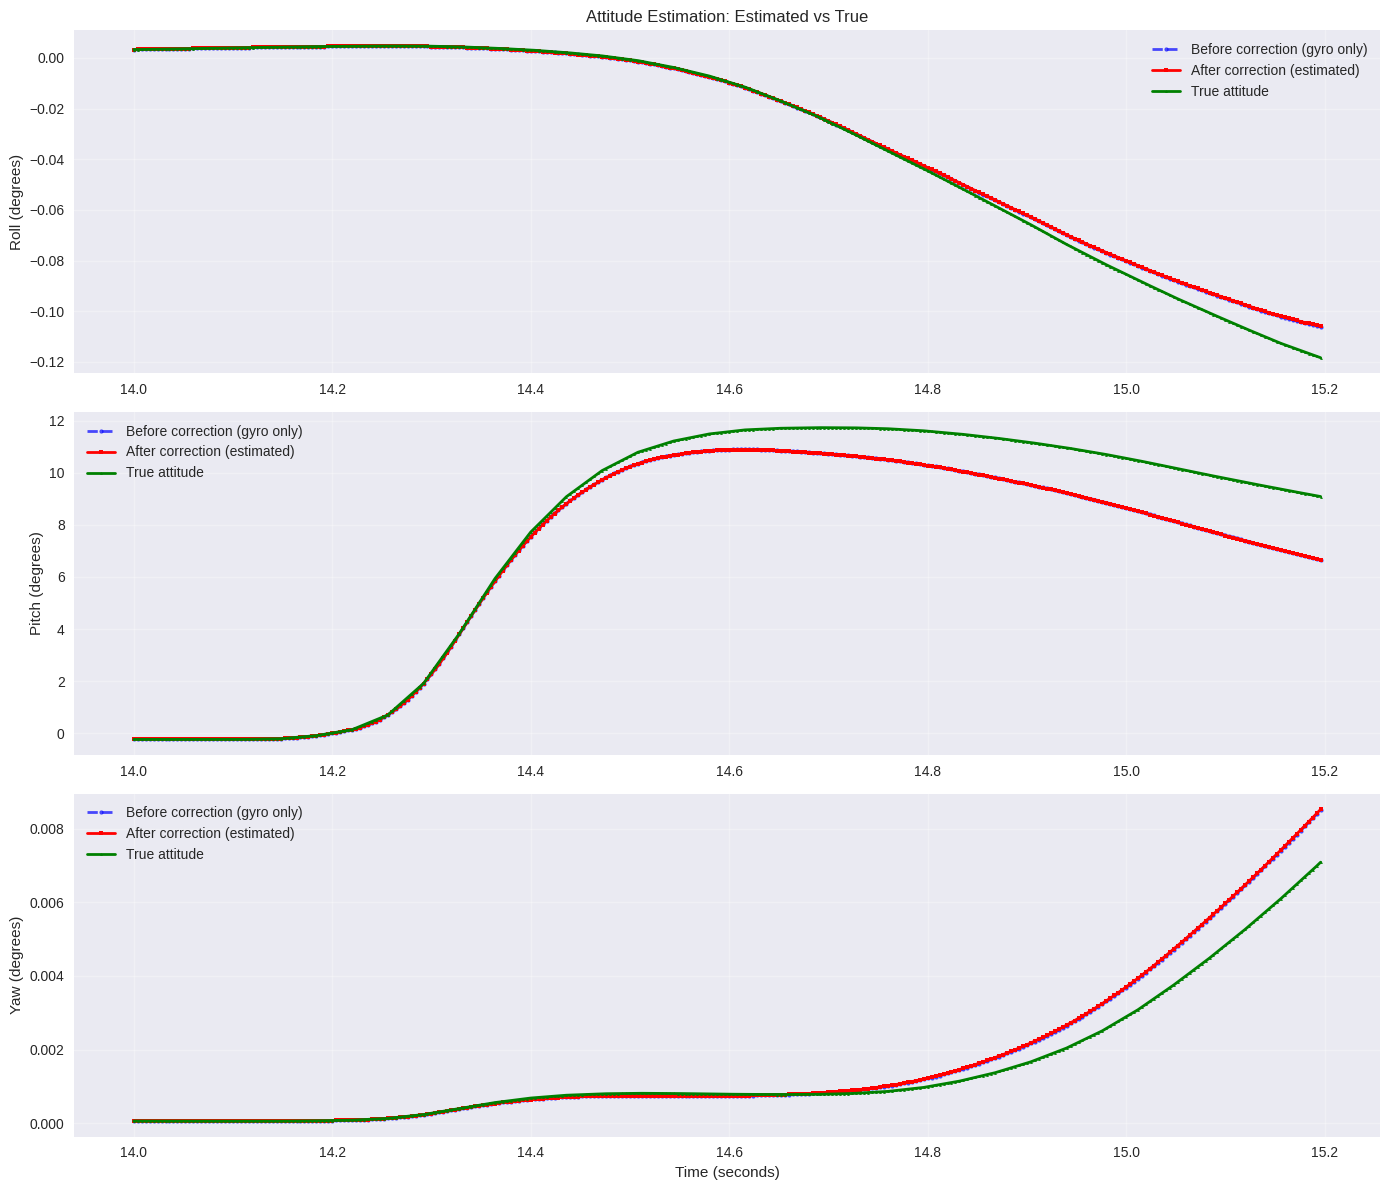

In [232]:
if 'time_array' in locals():
    # Plot attitude comparison
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Roll
    axes[0].plot(time_array, euler_before[:, 0], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[0].plot(time_array, euler_after[:, 0], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[0].plot(time_array, true_attitude_interp['roll'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[0].set_ylabel('Roll (degrees)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('Attitude Estimation: Estimated vs True')
    
    # Pitch
    axes[1].plot(time_array, euler_before[:, 1], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[1].plot(time_array, euler_after[:, 1], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[1].plot(time_array, true_attitude_interp['pitch'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[1].set_ylabel('Pitch (degrees)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Yaw
    axes[2].plot(time_array, euler_before[:, 2], 'b--o', label='Before correction (gyro only)', 
                linewidth=2, markersize=3, alpha=0.7)
    axes[2].plot(time_array, euler_after[:, 2], 'r-s', label='After correction (estimated)', 
                linewidth=2, markersize=3)
    axes[2].plot(time_array, true_attitude_interp['yaw'].iloc[:len(time_array)], 'g-^', 
                label='True attitude', linewidth=2, markersize=2)
    axes[2].set_ylabel('Yaw (degrees)')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot!")


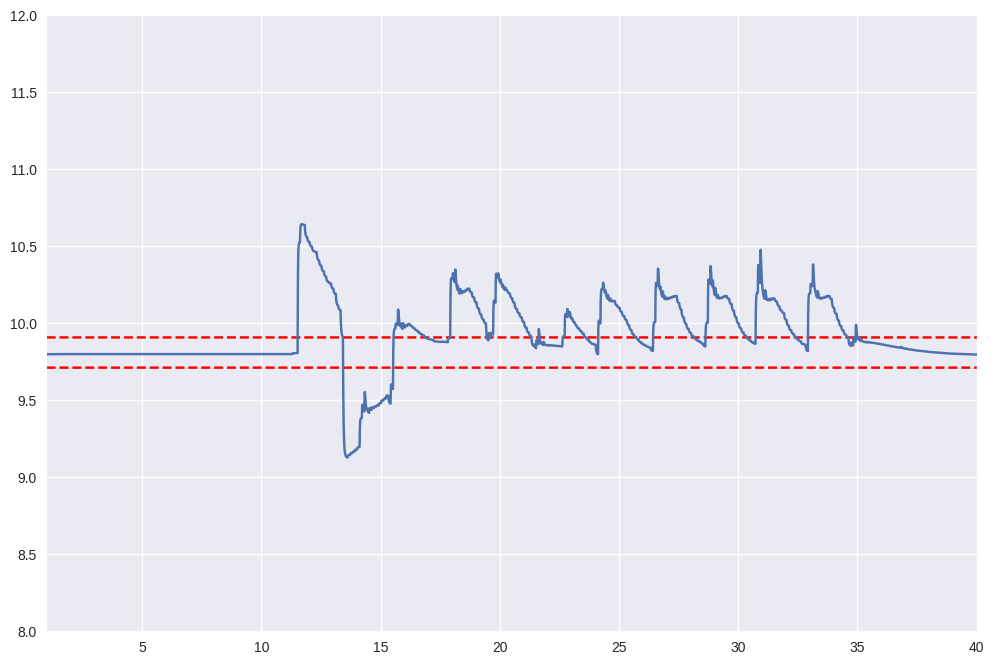

In [233]:
accel_norm = np.sqrt(imu_data['accel_x']**2 + imu_data['accel_y']**2 + imu_data['accel_z']**2)
g_high = 9.81 * 1.01
g_low = 9.81 * 0.99
plt.plot(imu_data['timestamp'], g_high * np.ones(len(imu_data['timestamp'])), 'r--')
plt.plot(imu_data['timestamp'], g_low * np.ones(len(imu_data['timestamp'])), 'r--')
plt.plot(imu_data['timestamp'], accel_norm)
plt.xlim(1, 40)
plt.ylim(8, 12)
plt.show()
